<a href="https://colab.research.google.com/github/davepy99/RecyclAI/blob/main/Recyclizer_(Garbage_Classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sumn2u_garbage_classification_v2_path = kagglehub.dataset_download('sumn2u/garbage-classification-v2')

print('Data source import complete.')


Data source import complete.


<h1> 1.1. Importing libraries </h1>

In [1]:
import shutil
import random
import os, cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pathlib import Path
from sklearn import metrics
from tensorflow import keras
import matplotlib.pyplot as plt

from keras.regularizers import l2
from sklearn.model_selection import train_test_split

<h1> 1.2. Deleting images with unsupported formats </h1>

In [3]:
SOURCE_PATH = Path("/kaggle/input/garbage-classification-v2")
DATASET_PATH = Path("/kaggle/working/garbage-classification-v2")


DATASET_PATH.mkdir(parents = True, exist_ok = True)

count = 0
skipped = 0

for filepath in SOURCE_PATH.rglob("*"):

    if filepath.is_file():

        try:

            img_raw = tf.io.read_file(str(filepath))
            _ = tf.image.decode_image(img_raw)

            # Determine the relative path and create target folder
            relative_path = filepath.relative_to(SOURCE_PATH)
            target_path = DATASET_PATH / relative_path
            target_path.parent.mkdir(parents = True, exist_ok = True)

            # Copy valid image
            shutil.copy2(filepath, target_path)
            count += 1

        except Exception as e:
            skipped += 1


print(f"✅ Copied {count} valid images to: {DATASET_PATH}")
print(f"❌ Skipped {skipped} invalid or unsupported images")

✅ Copied 19759 valid images to: /kaggle/working/garbage-classification-v2
❌ Skipped 3 invalid or unsupported images


<h1> 1.3. Defining Constants </h1>

In [8]:
# Dataset

DATASET_PATH = "/kaggle/working/garbage-classification-v2/garbage-dataset"
DATASET = sorted(os.listdir(DATASET_PATH))

TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2

# Image Shape

IMAGE_SIZE = 224
COLOR_CHANNELS = 3
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, COLOR_CHANNELS)

# Classes

NUM_CLASSES = 10
CLASSES = ["battery", "biological", "cardboard", "clothes", "glass",
           "metal", "paper", "plastic", "shoes", "trash"]


# Categories

CLASS_TO_CATEGORY = {

    "battery": "Hazardous",
    "biological": "Organic",
    "cardboard": "Recyclable",
    "clothes": "Recyclable",
    "glass": "Recyclable",
    "metal": "Recyclable",
    "paper": "Recyclable",
    "plastic": "Recyclable",
    "shoes": "Recyclable",
    "trash": "Non-recyclable"

}

# Model Parameters

POOLING_TYPE = 'max'
NUM_EPOCHS = 100
BATCH_SIZE = 32

# Callbacks

EARLY_STOPPING = keras.callbacks.EarlyStopping(

    monitor = 'val_loss',
    patience = 10,
    restore_best_weights = True,

)

REDUCE_LR = keras.callbacks.ReduceLROnPlateau(

    monitor = 'val_loss',
    patience = 4,
    factor = 0.5,
    min_lr = 1e-7,

)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/garbage-classification-v2/garbage-dataset'

<h1> 1.4. Loading Data </h1>

In [5]:
def load_data():

    image_paths, labels = [], []

    for label, folder_name in enumerate(DATASET):

        folder_path = os.path.join(DATASET_PATH, folder_name)
        folder = os.listdir(folder_path)

        for image_name in folder:

            image_path = os.path.join(folder_path, image_name)

            image_paths.append(image_path)
            labels.append(label)

    return image_paths, labels

In [6]:
# 75% train, 20% validation, 5% test

image_paths, labels = load_data()

X_train, X_temp, y_train, y_temp = train_test_split(

    image_paths,
    labels,
    test_size = 0.25,
    stratify = labels,
    random_state = 42

)

X_val, X_test, y_val, y_test = train_test_split(

    X_temp,
    y_temp,
    test_size = 0.2,
    stratify = y_temp,
    random_state = 42

)

<h1> 1.5. Preprocessing Data </h1>

In [7]:
def preprocess(path, label):

  image = tf.io.read_file(path)
  image = tf.io.decode_jpeg(image, channels = 3)
  image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
  image = keras.applications.resnet.preprocess_input(image)

  return image, label

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE * 2).prefetch(tf.data.AUTOTUNE)

<h1> 1.7. Computing Class Weights to handle imbalance </h1>

In [9]:
def class_weight(class_count):
    return len(y_train) / (NUM_CLASSES * class_count)

In [10]:
train_counts = pd.Series(y_train).value_counts().sort_index()

class_weights = {
    label: class_weight(count) for label, count in train_counts.items()
}

print(class_weights)

{0: 2.093079096045198, 1: 1.981149732620321, 2: 1.0824689554419284, 3: 0.37093867334167707, 4: 0.6457080610021787, 5: 1.937124183006536, 6: 1.177980922098569, 7: 0.9959005376344086, 8: 0.9992582602832097, 9: 2.087183098591549}


<h1> 2.1. Visualizing Random Images </h1>

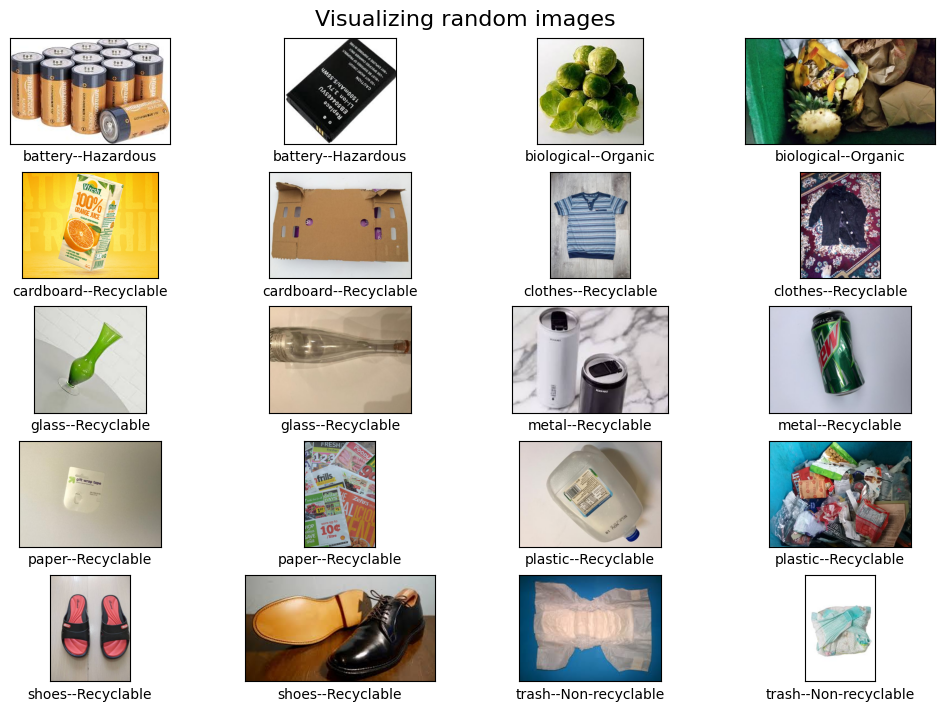

In [11]:
plt.figure(figsize = (10, 7), constrained_layout = True)
plt.suptitle('Visualizing random images', fontsize = 16)

position = 1

for class_name in DATASET:

    folder_path = os.path.join(DATASET_PATH, class_name)
    folder = os.listdir(folder_path)
    random_images = random.sample(folder, 2)

    for image_name in random_images:

        # Reading the image

        image_path = os.path.join(folder_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Plotting the image

        plt.subplot(5, 4, position)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image)
        plt.xlabel(f'{class_name}--{CLASS_TO_CATEGORY[class_name]}')

        position += 1

plt.show()

<h1> 2.2. Dataset shapes </h1>

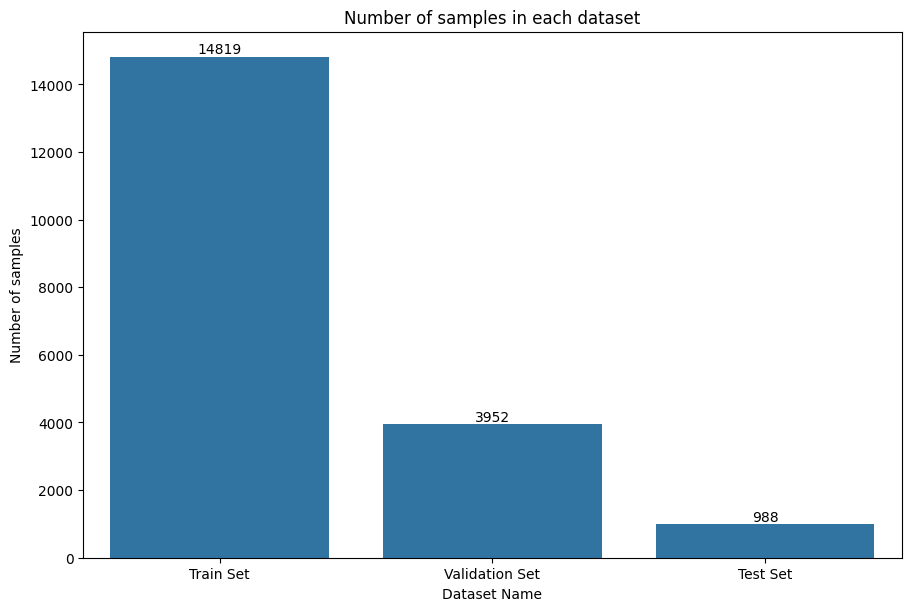

In [12]:
dataset_names = ['Train Set', 'Validation Set', 'Test Set']

dataset_shapes = [len(X_train), len(X_val), len(X_test)]
dataset_shapes = np.array(dataset_shapes, dtype = 'int32')

plt.figure(figsize = (9, 6), constrained_layout = True)

ax = sns.barplot(x = dataset_names, y = dataset_shapes)
ax.bar_label(ax.containers[0])

plt.xlabel('Dataset Name')
plt.ylabel('Number of samples')
plt.title('Number of samples in each dataset')

plt.show()

<h1> 2.3. Class Distribution </h1>

In [13]:
class_samples = pd.Series(labels).value_counts().sort_index()
print(class_samples)

0     944
1     997
2    1825
3    5327
4    3061
5    1020
6    1677
7    1984
8    1977
9     947
Name: count, dtype: int64


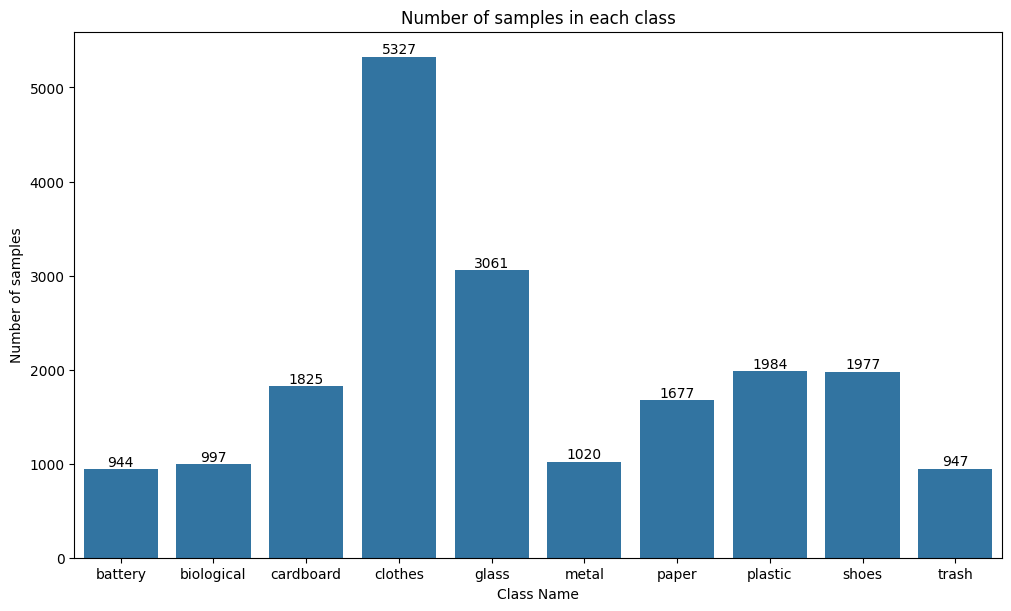

In [14]:
plt.figure(figsize = (10, 6), constrained_layout = True)

ax = sns.barplot(x = CLASSES, y = class_samples)
ax.bar_label(ax.containers[0])

plt.xlabel('Class Name')
plt.ylabel('Number of samples')
plt.title('Number of samples in each class')

plt.show()

<h1> 2.4. Class distribution using Pie Chart </h1>

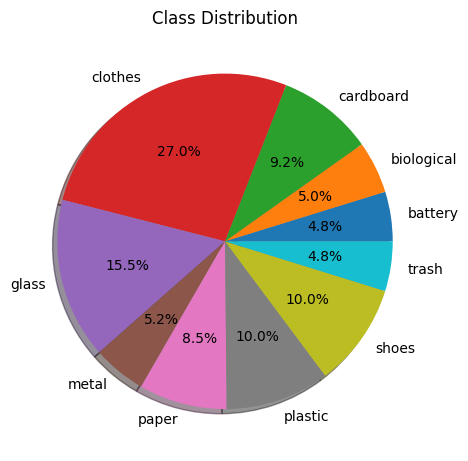

In [15]:
plt.figure(figsize = (6.5, 4.5), constrained_layout = True)

plt.pie(class_samples, labels = CLASSES, autopct = '%1.1f%%',
        pctdistance = 0.6, shadow = True)

plt.title('Class Distribution')
plt.show()

<h1> 2.5. Distribution of classes in each category </h1>

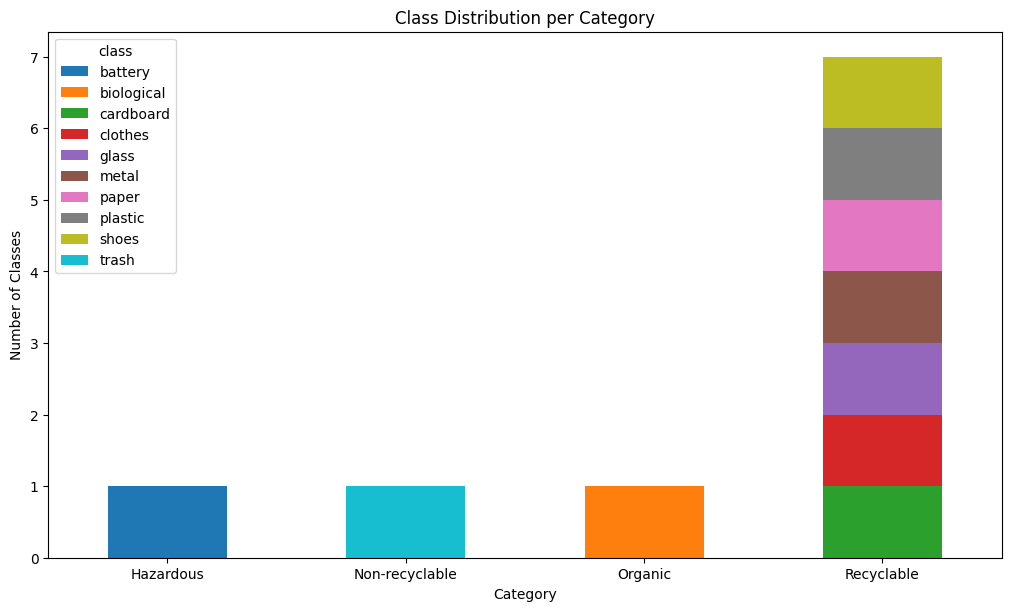

In [16]:
df = pd.DataFrame(CLASS_TO_CATEGORY.items(), columns=["class", "category"])
classes_count = df.groupby("category")["class"].value_counts().unstack()

fig, ax = plt.subplots(figsize = (10, 6), constrained_layout = True)
classes_count.plot(kind = "bar", stacked = True, ax = ax, colormap = "tab10")

ax.set_xlabel("Category")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
ax.set_ylabel("Number of Classes")
ax.set_title("Class Distribution per Category")

plt.show()

<h1> 3. Model </h1>

<h1> 3.1. Defining the model </h1>

In [17]:
# Using the pre-trained ResNet model

base_model = keras.applications.ResNet50(

    include_top = False,
    weights = 'imagenet',
    pooling = POOLING_TYPE,
    input_shape = IMAGE_SHAPE

)

base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [18]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [19]:
model = keras.models.Sequential([

    base_model,
    keras.layers.Dense(512, activation = 'relu', kernel_regularizer = l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation = 'relu', kernel_regularizer = l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(NUM_CLASSES, activation = 'softmax')

])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

<h1> 3.2. Training the model </h1>

In [20]:
history = model.fit(

    train_ds,
    epochs = NUM_EPOCHS,
    validation_data = (val_ds),
    class_weight = class_weights,
    callbacks = [EARLY_STOPPING, REDUCE_LR]

)

Epoch 1/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 92s 165ms/step - accuracy: 0.6213 - loss: 11.4890 - val_accuracy: 0.8768 - val_loss: 3.9257 - learning_rate: 0.0010
Epoch 2/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 69s 148ms/step - accuracy: 0.8298 - loss: 3.4710 - val_accuracy: 0.8897 - val_loss: 1.8052 - learning_rate: 0.0010
Epoch 3/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 73s 129ms/step - accuracy: 0.8643 - loss: 1.7157 - val_accuracy: 0.9094 - val_loss: 1.0749 - learning_rate: 0.0010
Epoch 4/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 68s 146ms/step - accuracy: 0.8627 - loss: 1.1698 - val_accuracy: 0.8715 - val_loss: 0.9115 - learning_rate: 0.0010
Epoch 5/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - accuracy: 0.8648 - loss: 0.9546 - val_accuracy: 0.9036 - val_loss: 0.7234 - learning_rate: 0.0010
Epoch 6/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 60s 129ms/step - accuracy: 0.8764 - loss: 0.8393 - val_accuracy: 0.9038 - val_loss: 0.6859 - learning_rate: 0.0010
Epoch 7/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 90s 145ms/step - accur

<h1> 3.3. Exporting Model Architecture and Weights </h1>

In [21]:
model.save('/keggle/working/resnet50_custom.h5')
model.save('/content/resnet50_custom.h5')

In [34]:
model.save('/content/resnet50_custom.keras')

<h1> 4. Model Evaluation </h1>

<h1> 4.1. Training and Validation Accuracy </h1>

In [22]:
train_accuracies = history.history['accuracy']
val_accuracies = history.history['val_accuracy']

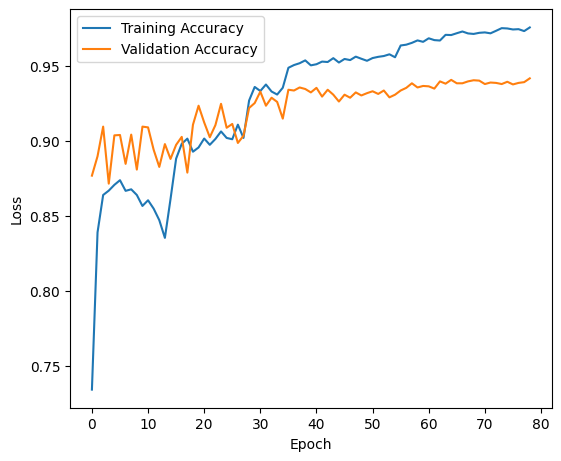

In [23]:
plt.figure(figsize = (5.5, 4.5), constrained_layout = True)

plt.plot(train_accuracies, label = 'Training Accuracy')
plt.plot(val_accuracies, label = 'Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [24]:
print(f'Train Accuracy: {round(train_accuracies[-1], 2) * 100}%')
print(f'Validation Accuracy: {round(val_accuracies[-1], 2) * 100}%')

Train Accuracy: 98.0%
Validation Accuracy: 94.0%


<h1> 4.2. Training and Validation Loss </h1>

In [25]:
train_losses = history.history['loss']
val_losses = history.history['val_loss']

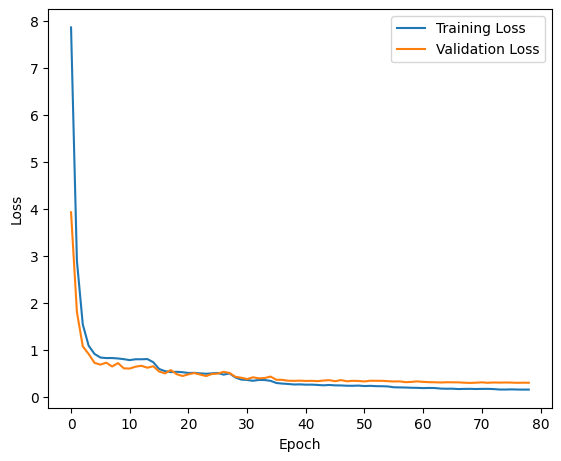

In [26]:
plt.figure(figsize = (5.5, 4.5), constrained_layout = True)

plt.plot(train_losses, label = 'Training Loss')
plt.plot(val_losses, label = 'Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [27]:
print(f'train Losses: {round(train_losses[-1], 2) * 100}%')
print(f'Validation Losses: {round(val_losses[-1], 2) * 100}%')

train Losses: 15.0%
Validation Losses: 30.0%


<h1> 4.3. Getting Predicted labels </h1>

In [28]:
y_val = np.concatenate([labels for imgs, labels in val_ds])

prob_arrays = model.predict(val_ds)
y_pred = [prob_arr.argmax() for prob_arr in prob_arrays]

print("Validation labels shape:", len(y_val))
print("Predict labels shape:", len(y_pred))

62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 277ms/step
Validation labels shape: 3952
Predict labels shape: 3952


<h1> 4.4. Confusion Matrix </h1>

<Axes: >

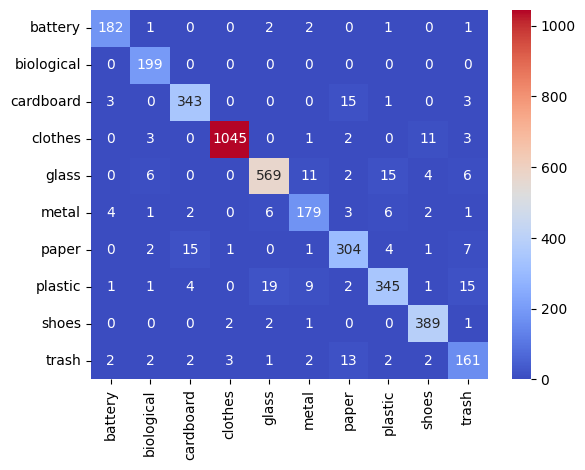

In [29]:
cm = metrics.confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot = True, fmt = '.0f', cmap = 'coolwarm', xticklabels = CLASSES, yticklabels = CLASSES)

<h1> 4.5. Classifcation Report </h1>

In [30]:
report = metrics.classification_report(y_val, y_pred, target_names = CLASSES)
print(report)

              precision    recall  f1-score   support

     battery       0.95      0.96      0.96       189
  biological       0.93      1.00      0.96       199
   cardboard       0.94      0.94      0.94       365
     clothes       0.99      0.98      0.99      1065
       glass       0.95      0.93      0.94       613
       metal       0.87      0.88      0.87       204
       paper       0.89      0.91      0.90       335
     plastic       0.92      0.87      0.89       397
       shoes       0.95      0.98      0.97       395
       trash       0.81      0.85      0.83       190

    accuracy                           0.94      3952
   macro avg       0.92      0.93      0.92      3952
weighted avg       0.94      0.94      0.94      3952



In [31]:
# Average Precision, Recall and F1 Scores

precision = metrics.precision_score(y_pred, y_val, average = 'weighted')
recall = metrics.recall_score(y_pred, y_val, average = 'weighted')
f1_score = metrics.f1_score(y_pred, y_val, average = 'weighted')

print(f'Precision Score = {round(precision, 2) * 100}%')
print(f'Recall Score = {round(recall, 2) * 100}%')
print(f'F1 Score = {round(f1_score, 2) * 100}%')

Precision Score = 94.0%
Recall Score = 94.0%
F1 Score = 94.0%


<h1> 4.6. Predicting Random Images </h1>

In [6]:
def predict(image_path):

    image = cv2.imread(image_path)

    # Processing the image
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_arr = np.expand_dims(image, axis = 0)
    image_arr = keras.applications.resnet.preprocess_input(image_arr)

    # Predicting the label
    prob_array = model.predict(image_arr, verbose = 0)
    label = prob_array.argmax()
    class_name = CLASSES[label]

    return image, class_name

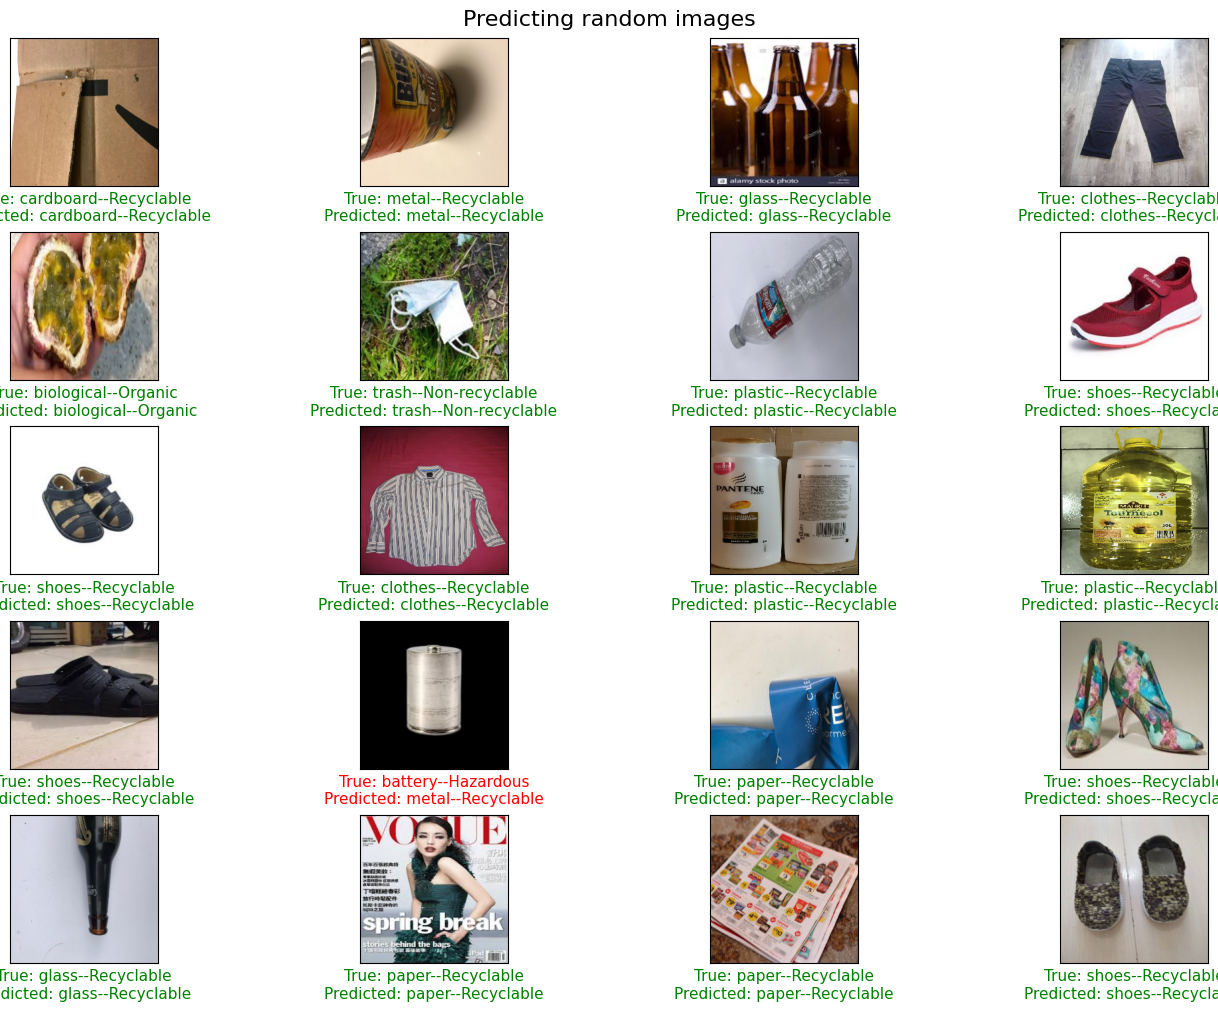

In [33]:
plt.figure(figsize = (14, 10), constrained_layout = True)
plt.suptitle('Predicting random images', fontsize = 16)

for ind in range(20):

    # Getting true values
    image_path = X_test[ind]
    true_label = CLASSES[y_test[ind]]

    # Getting predicted values
    image, pred_label = predict(image_path)

    # Preparing the subplot
    plt.subplot(5, 4, ind + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Displaying the image
    plt.imshow(image)

    # Checking true and predicted values match

    true_str = f'True: {true_label}--{CLASS_TO_CATEGORY[true_label]}'
    pred_str = f'Predicted: {pred_label}--{CLASS_TO_CATEGORY[pred_label]}'

    xlabel_str = f'{true_str}\n{pred_str}'
    color = 'green' if true_label == pred_label else 'red'

    plt.xlabel(xlabel_str, color = color, fontsize = 11)

plt.show()

In [2]:
from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive

# Save your model to Colab's local storage (runtime)
# model.save('/content/resnet50_custom.keras')

# Copy the saved file to Google Drive (adjust the path as needed)
# !cp /content/resnet50_custom.keras "/content/drive/MyDrive/my_model.keras"


Mounted at /content/drive


In [36]:
# Copy the saved file to Google Drive (adjust the path as needed)
!cp /content/resnet50_custom.keras "/content/drive/MyDrive/Data&AI Project/CNN Project"

In [4]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image as keras_image
import matplotlib.pyplot as plt

model_path = "/content/drive/MyDrive/Data&AI Project/CNN Project/resnet50_custom.keras"
model = load_model(model_path)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Predicted: paper--Recyclable


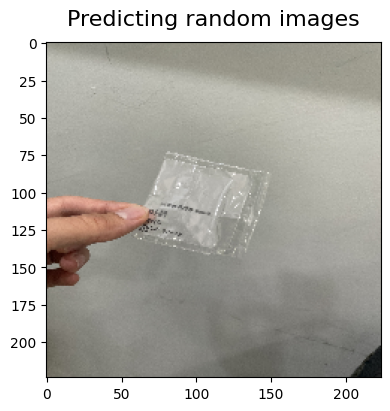

In [22]:
plt.figure(figsize = (5, 4), constrained_layout = True)
plt.suptitle('Predicting random images', fontsize = 16)

IMAGE_SIZE = 224

NUM_CLASSES = 10
CLASSES = ["battery", "biological", "cardboard", "clothes", "glass",
           "metal", "paper", "plastic", "shoes", "trash"]

CLASS_TO_CATEGORY = {

    "battery": "Hazardous",
    "biological": "Organic",
    "cardboard": "Recyclable",
    "clothes": "Recyclable",
    "glass": "Recyclable",
    "metal": "Recyclable",
    "paper": "Recyclable",
    "plastic": "Recyclable",
    "shoes": "Recyclable",
    "trash": "Non-recyclable"

}

image_path = "/content/drive/MyDrive/Data&AI Project/CNN Project/IMG_2952.JPG"
image, pred_label = predict(image_path)
plt.imshow(image)
pred_str = f'Predicted: {pred_label}--{CLASS_TO_CATEGORY[pred_label]}'
print(pred_str)
plt.show()